In [1]:
import pandas as pd
import yaml
from pathlib import Path

from experiments import get_experiments_root_path
from models.base import get_models_root_path
from config import Config, global_config
from visuals import plot_precision_recall_curve, plot_counts_vs_threshold, plot_label_counts

2023-06-18 14:40:17.458010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 14:40:17.583574: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-18 14:40:17.587692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-18 14:40:17.587705: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
exp_name = 'liwc2015-root9_vs_opted-top10'

In [3]:
config_path = get_experiments_root_path() / exp_name / f'{exp_name}__conf.yaml'
with open(config_path) as config_file:
	exp = Config(yaml.safe_load(config_file))

In [4]:
dict_names = [d.name for d in exp.dictionaries]

In [5]:
def load_test_out(d_name: str) -> pd.DataFrame:
	path = get_models_root_path() / f'{exp_name}__{exp_name}_{d_name}' / f'{exp_name}__{exp_name}_{d_name}__test_out.csv'
	return pd.read_csv(path, index_col=0)

tests_labeled = {d_name: load_test_out(d_name) for d_name in dict_names}

In [12]:
def load_labeled_dict(d_name: str) -> pd.DataFrame:
	path = Path(global_config.storage.root) / global_config.storage.labeled_out / exp_name / f'{d_name}.csv'
	df = pd.read_csv(path, index_col=0)
	#df = df[pd.isna(df.label)]
	if 'quality' in df:
		df = df[df.quality > 0]
	df = df.sort_values(by='prob_out', ascending=False).groupby(by='word', as_index=False).head(1)
	return df
labeled_dicts = {d_name: load_labeled_dict(d_name) for d_name in dict_names}

### Training set record count

In [13]:
{name: f'{d.train_count:,}' for name, d in zip(dict_names, exp.datasets)}

{'opted': '11,765'}

### F-score

In [14]:
{d_name: f'{r.f_score:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'opted': '0.53'}

### Precision

In [15]:
{d_name: f'{r.report["macro avg"].precision:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'opted': '0.54'}

### Recall

In [16]:
{d_name: f'{r.report["macro avg"].recall:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'opted': '0.54'}

### Accuracy

In [17]:
{d_name: f'{r.accuracy:.2f}' for d_name, r in zip(dict_names, exp.results)}

{'opted': '0.60'}

### Precision/Recall Curves

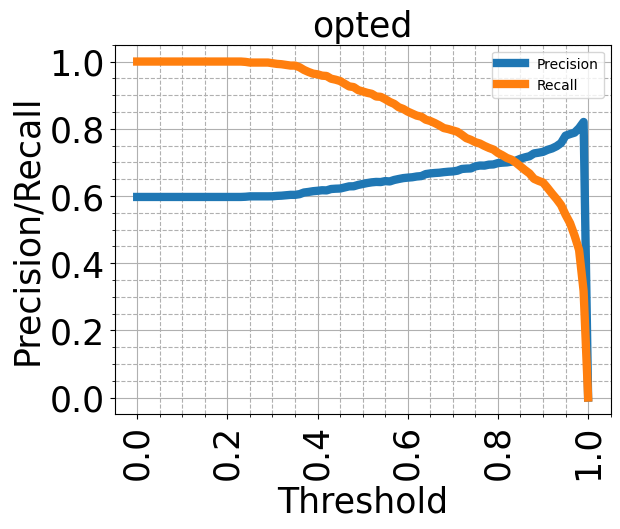

In [18]:
thr_pr_recalls = {d_name: plot_precision_recall_curve(df, title=d_name) for d_name, df in tests_labeled.items()}

### New terms count versus model confidence

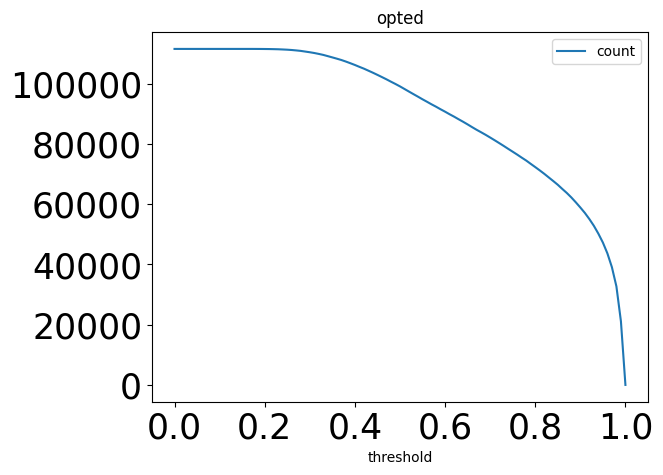

In [19]:
counts_vs_thresholds = {d_name: plot_counts_vs_threshold(df, title=d_name) for d_name, df in labeled_dicts.items()}

### Summary

In [20]:
prob_thr = 0.98

In [21]:
def print_stats(d_name: str, thr: float):
	pr, recall = thr_pr_recalls[d_name][thr]
	new_count = counts_vs_thresholds[d_name][thr]
	print(f'{d_name}: Precision {pr:.2f} Recall: {recall:.2f} New terms count {new_count:,}')
	df = labeled_dicts[d_name]
	df = df[df.prob_out >= thr]
	plot_label_counts(df.label_out, title=d_name)

opted: Precision 0.80 Recall: 0.44 New terms count 32,724


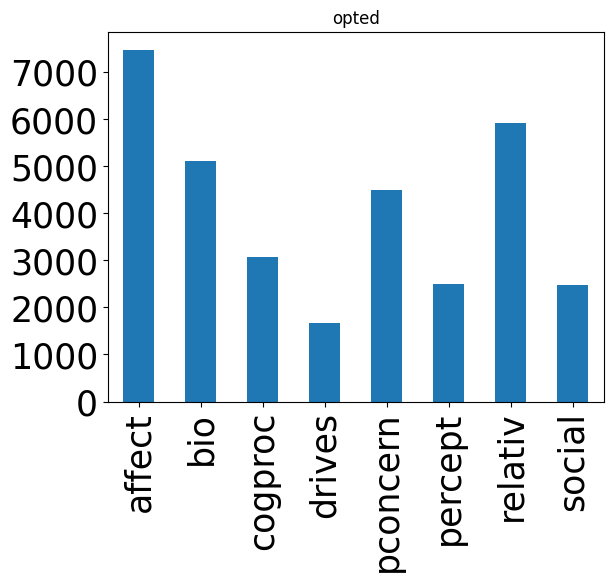

In [23]:
print_stats('opted', prob_thr)